In [535]:
%run Make_Questiones.ipynb
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time


In [536]:
N = 3
#M = 5
I = 2
J = 3
K = 5
Channel_upperbound = 5
Data_upperbound = 20
Processing_upperbound = 70
self_looped = 100

In [537]:
Channel_link = Create_channel(N,Channel_upperbound,option = "same",initial_length = 1)
#print(Channel_link)

In [538]:
Data_input = Data_Queue(I,J,Data_upperbound)
Data_input_type = Data_Queue_type(I,J,K)
VM_type = VM_Data_type_gen(I,K,N)
VM_speed = VM_Data_processing_speed(Processing_upperbound, VM_type, K)
#print(Data_input_type)
print(VM_type)
print(Data_input_type)

[[1 2 4 5]
 [1 2 3 4]
 [1 2 4 5]]
[[3 4 5]
 [3 1 4]]


In [539]:
print(np.shape(VM_DP_time),np.shape( Data_input_type),np.shape(VM_speed))

VM_DP_time = VM_Data_processing_time(Data_input, Data_input_type , VM_speed)


(2, 3, 3) (2, 3) (3, 5)


In [540]:
Transmission_time = Channel_Data_transmission_time(Data_input , Channel_link)

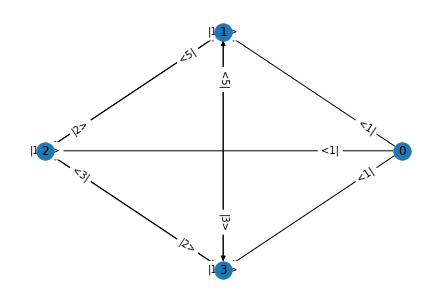

In [541]:
Draw_network(Channel_link)

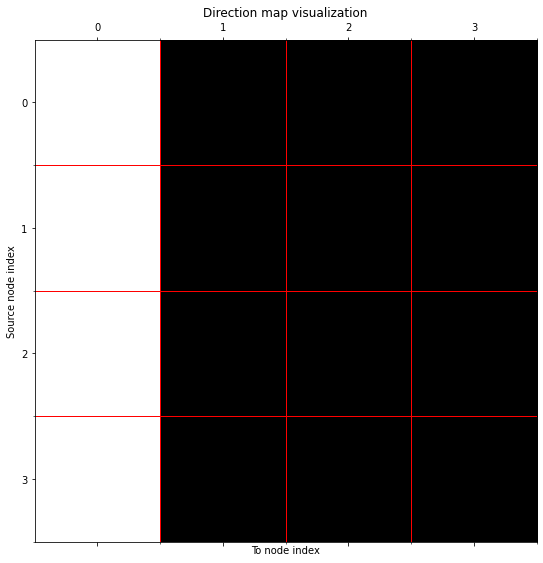

In [542]:
show_relation(np.sign(Channel_link))

In [543]:
next_index,_ = np.where(VM_type==5)
print(next_index)
#print(y_index)

[0 2]


In [555]:
#VM_DP_time

In [547]:
modified_VM_DP_time = VM_DP_time
modified_VM_DP_time[np.isinf(modified_VM_DP_time)]=0
print("每个任务的经过未知机器处理的最大时间")
print(np.max(modified_VM_DP_time[:,:,:],2))
T_max_DP = np.sum(np.max(modified_VM_DP_time[:,:,:],2))
print("Worst case processing T_max 为:", T_max_DP)

每个任务的经过未知机器处理的最大时间
[[1. 2. 2.]
 [1. 2. 1.]]
Worst case processing T_max 为: 9.0


In [548]:
modified_Transmission_time = Transmission_time[:,1:,:,1:]
modified_Transmission_time[np.isinf(modified_Transmission_time)] = 0  #可不做（只要左，上需要从除去inf，除非不是全连接图）
print(np.shape(modified_Transmission_time))
print("每个任务的经过未知link的最大时间")
print(np.max(modified_Transmission_time,(1,3)))

T_max_DT = np.sum(np.max(modified_Transmission_time,(1,3)))

print("Worst case of transmission T_max 为:", T_max_DT)

(2, 3, 3, 3)
每个任务的经过未知link的最大时间
[[7. 9. 7.]
 [9. 4. 4.]]
Worst case of transmission T_max 为: 40.0


In [549]:
T_max = int(T_max_DP + T_max_DT )
print("Worst case of whole DT + DP T_max 为:", T_max)

Worst case of whole DT + DP T_max 为: 49


In [550]:
print("let t = 1 unit of time")

let t = 1 unit of time


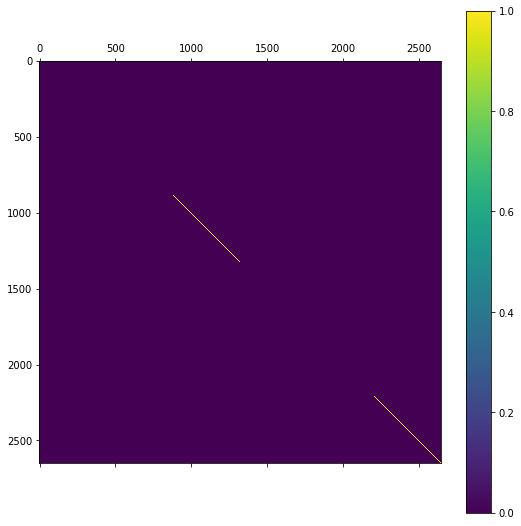

In [551]:
#Obj QUBO dont flatten yet
w = np.zeros((I,J,N,N,T_max))
w[:,J-1,:,:,:] = 1
QUBO_0 = np.diag(w.flatten())
#print(QUBO)
show_graph(QUBO_0)

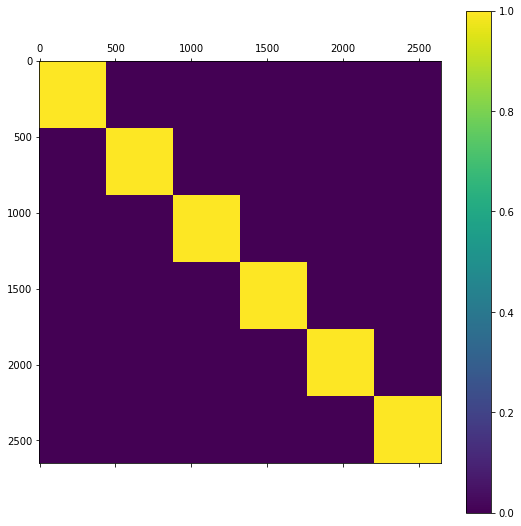

In [552]:
#C2
P2 = np.ones((I,J))
QUBO_2 = np.zeros_like(QUBO_0)

#print(P2)
for i in range(I):
    for j in range(J):
        w = np.zeros((I,J,N,N,T_max))
        w[i,j,:,:,:] = 1    
        QUBO_2 += P2[i,j]*np.outer(w.flatten(),w.flatten())
        
show_graph(QUBO_2)

[1] [1]
[0 1 2] [0 1 2]
[1] [1]
[0 1 2] [0 1 2]


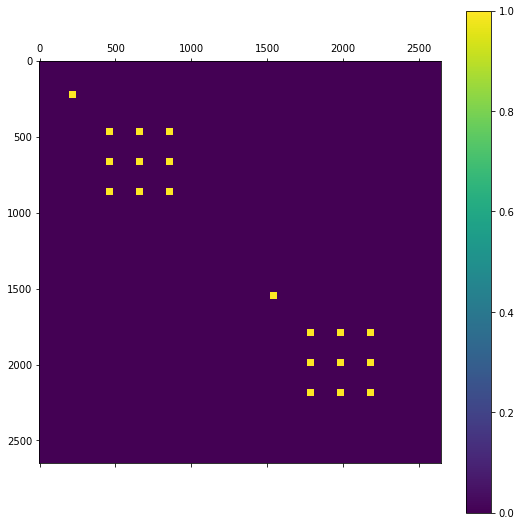

In [553]:
#C3 P 算错了 should be j-1
P3 = np.ones((I,J))
QUBO_3 = np.zeros_like(QUBO_0)

#print(P3)
for i in range(I):
    for j in range(J-1):
        
        w = np.zeros((I,J,N,N,T_max))
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j])
        print(V_ij_k,V_ijplus1_k)
        
        w[i,j,V_ij_k,V_ijplus1_k,:] = 1    
        QUBO_3 += P3[i,j]*np.outer(w.flatten(),w.flatten())

show_graph(QUBO_3)
        
        


In [531]:
position_dictionary = {}
print(I,J,N)

2 3 3


In [533]:
# set-up a dictionary

# x input
for i in range(I):
    for j in range(J):
        for m in range(N):
            for n in range(N):
                for t in range(T_max):
                    
                    multiplier = np.array([i,j,m,n,t])
                    unit = np.array([J*T_max*N**2,T_max*N**2,T_max*N,T_max,1])
                    #print(np.dot(multiplier,unit))
                    position_dictionary["X_%d%d%d%d%d"%(i,j,m,n,t)] = np.dot(multiplier,unit)

Var_X_num = len(position_dictionary)
# y input
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                multiplier = np.array([i,j,m,t])
                unit = np.array([J*T_max*N,,T_max*N,T_max,1])
                #print(np.dot(multiplier,unit))
                position_dictionary["X_%d%d%d%d%d"%(i,j,m,n,t)] = np.dot(multiplier,unit) + Var_X_num
                
#

In [534]:
len(position_dictionary)

2160

In [471]:
m = N
n = N
t = 1
"X_%d%d%d%d%d"%(i,j,m,n,t)

'X_11331'

In [472]:
multiplier = np.array([i,j,m,n,t])
unit = np.array([J*T_max*N**2,T_max*N**2,T_max*N,T_max,1])
np.dot(multiplier,unit)

4225